In [16]:
import os
from operator import add
from typing_extensions import TypedDict, Annotated
import yaml
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import AnyMessage, add_messages
import openai
from pydantic import BaseModel, Field

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
with open("prompts.yaml", "r") as file:
    PROMPTS = yaml.safe_load(file)

In [17]:
class Task(BaseModel):
    """`Task` object repesents a general subproblem, decomoposed from the orginal `input_problem` of the user"""
    name: str = Field(..., description="Name of the task")
    description: str = Field(..., 
                             description="Essential description with details of the task, including the expected output", 
                             examples=[{"task": "what is the capital of France?", "expected_output": "city name"},
                                       {"task": "who many times does the 'r' letter appear in strawberry?", "expected_output": "number of r's"}])
    

class SolvedTask(Task):
    """`SolvedTask` object represents a task that has been solved by the system"""
    solution: str = Field(..., description="The solution of the task")
    

class InputState(BaseModel):
    input_problem: str = Field(..., description="The original problem statement given by the user")
    task: Task = Field(..., description="The current task to be solved")
    task_history: list[SolvedTask] = Field([], description="List of tasks that have been solved so far")


class OutputState(BaseModel):
    solution: str = Field("<<SOLUTION NOT FOUND>>", description="The solution of the task without the thought process and the explanation. If the solution is not found, the value is `<<SOLUTION NOT FOUND>>`")


class SchemaAgentState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages] = Field([])

In [ ]:
class SchemaSetup:
    def __call__(self, state: InputState) -> SchemaAgentState:
        prompt_template = SystemMessagePromptTemplate.from_template(template=PROMPTS["system_prompt"])
        prompt_template = prompt_template.format_messages(input_problem=state.input_problem, task_history=state.task_history, task=state.task)[0]
        setattr(prompt_template, "source_node", self.__class__.__name__)
        return {
            "messages": [prompt_template]
        }

In [ ]:
class Cognition:
    def __init__(self):
        self.cognition_llm = ChatOpenAI(model="gpt-4o", top_p=0.8)
        self.refine_cognition_llm = ChatOpenAI(model="gpt-4o", temperature=0.4)
        self.refine_counter = 0

    def __call__(self, state: SchemaAgentState) -> SchemaAgentState:
        if getattr(state.messages[-1], "source_node", None) == "SchemaSetup":
            return self.first_round_cognition(state)
        else:
            self.refine_counter += 1
            return self.refine_cognition(state)

    def first_round_cognition(self, state: SchemaAgentState) -> SchemaAgentState:
        ai_message = self.cognition_llm.invoke(state.messages)
        setattr(ai_message, "source_node", self.__class__.__name__)
        return {
            "messages": [ai_message]
        }

    def refine_cognition(self, state: SchemaAgentState) -> SchemaAgentState:
        context = state.messages + [HumanMessage(PROMPTS["refinement_prompt"], source_node=self.__class__.__name__)]
        ai_message = self.refine_cognition_llm.invoke(context)
        setattr(ai_message, "source_node", self.__class__.__name__)
        return {
            "messages": [context[-1], ai_message]
        }

In [ ]:
class PartialEvaluation:
    def __init__(self) -> None:
        self.partial_evaluation_llm = ChatOpenAI(model="gpt-4o", temperature=0.5, stop_sequences=["<</STOP>>"])

    def __call__(self, state: SchemaAgentState) -> SchemaAgentState:
        context = state.messages + [HumanMessage(PROMPTS["evaluation_prompt"], source_node=self.__class__.__name__)]
        ai_message = self.partial_evaluation_llm.invoke(context)
        setattr(ai_message, "source_node", self.__class__.__name__)
        setattr(ai_message, "is_ok", ai_message.content.endswith("<<OK>>"))
        return {
            "messages": [context[-1], ai_message]
        }

In [ ]:
class Resolution:
    def __init__(self) -> None:
        self.resolution_llm = (ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
                               .with_structured_output(OutputState))

    def __call__(self, state: SchemaAgentState) -> OutputState:
        return self.resolution_llm.invoke(state.messages
                                          + [HumanMessage(PROMPTS["resolution_prompt"], 
                                                          source_node=self.__class__.__name__)])

In [ ]:
setup = SchemaSetup()
cognition = Cognition()
evaluation = PartialEvaluation()
resolution = Resolution()

graph = StateGraph(SchemaAgentState, input=InputState, output=OutputState)
graph.add_node("setup", setup)
graph.add_node("cognition", cognition)
graph.add_node("partial_evaluation", evaluation)
graph.add_node("resolution", resolution)
graph.add_edge(START, "setup")
graph.add_edge("setup", "cognition")
graph.add_edge("cognition", "partial_evaluation")
graph.add_conditional_edges("partial_evaluation", 
                            lambda state: "resolve" if getattr(state.messages[-1], "is_ok", False) else "refine", 
                            {"resolve": "resolution", "refine": "cognition"})
graph.add_edge("resolution", END)
graph = graph.compile()

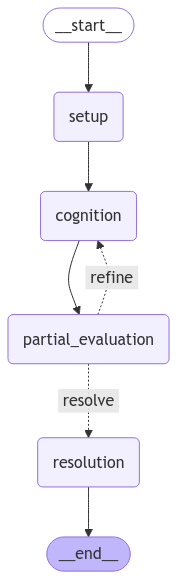

In [24]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))